# ClosePrice Prediction 2

In this notebook, I implemented the same model as in the original notebook, but I experimented a bit with Feature Engineering. Particulary, what I did was:


*   Included RATIO_CurrentPrice_By_SQFT in the model
*   Included RATIO_CurrentPrice_By_LotSizeAreaSQFT in the model
*   Created features based on StructuralStyle using the main values and grouping the rest under "Others"
*   Created features based on YearBuiltDetails using the main values and grouping the rest under "Others"

This resulted in a higher R2 in test and less overfitting.





R2 Score on Training Data: 0.9873
R2 Score on Test Data: 0.9461


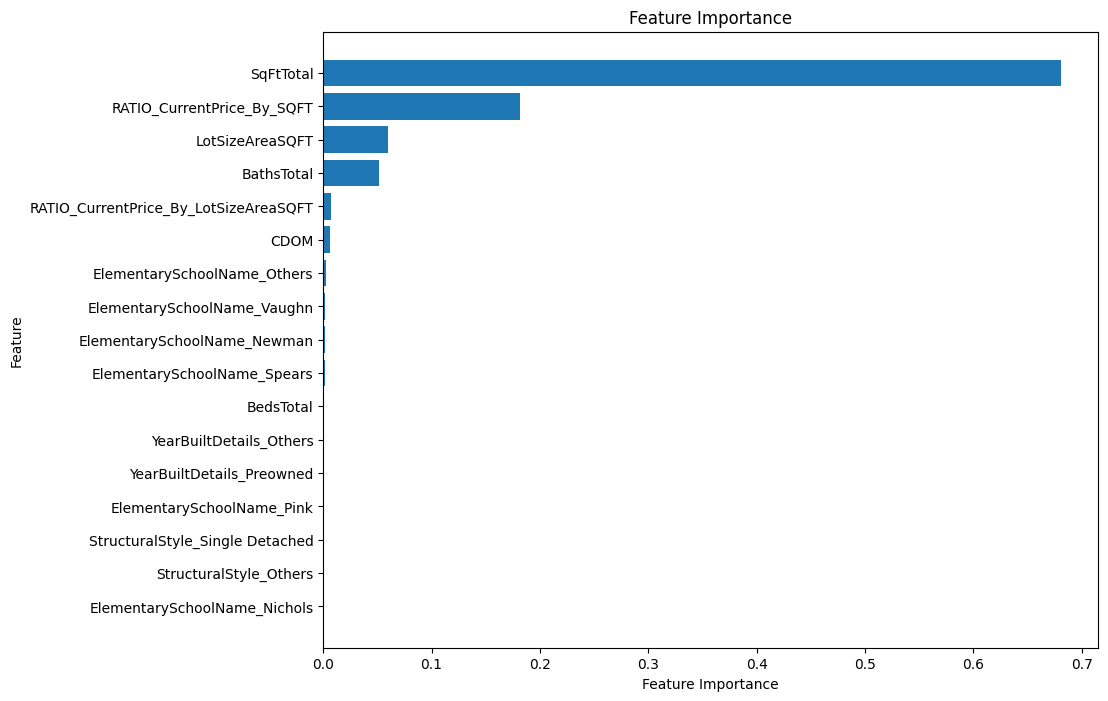

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import joblib
import matplotlib.pyplot as plt

#Load Data
def load_data(file_path):
  """
  Input: 'file_path' (str) - Path to the CSV file containing the data

  Output: 'DataFrame' - Pandas DataFrame containing the loaded data

  Description: Loads data from a CSV file into a Pandas DataFrame
  """
  return pd.read_csv(file_path)

#Preprocess data
def preprocess_data(df):
  """
  Input: 'df' (DataFrame) - Pandas DataFrame containing the raw data

  Output: 'X' (DataFrame), 'y' (Series) - Preprocessed features ('X') and target
  variable ('y').

  Description: Proprocessed the raw data by selecting relevant columns, removing
  outliers, encoding categorical variables, and splitting into features and
  target
  """
  df_reduced = df[['BathsTotal','BedsTotal','CDOM','LotSizeAreaSQFT','SqFtTotal',
                 'ElementarySchoolName', 'RATIO_CurrentPrice_By_SQFT','RATIO_CurrentPrice_By_LotSizeAreaSQFT',
                   'StructuralStyle','YearBuiltDetails','ClosePrice']]

  sold_houses = df_reduced[df_reduced['ClosePrice'] > 0]

  sold_houses = sold_houses[sold_houses['CDOM'] > 0]
  sold_houses = sold_houses[sold_houses['LotSizeAreaSQFT'] > 0]

  keep_school_names = ['Spears','Newman','Nichols','Vaughn','Pink']

  sold_houses['EncodedElementarySchoolName'] = 'Others'
  sold_houses.loc[sold_houses['ElementarySchoolName'].isin(keep_school_names),'EncodedElementarySchoolName'] = sold_houses['ElementarySchoolName']

  keep_structural_style = ['Single Detached']
  sold_houses['EncodedStructuralStyle'] = 'Others'
  sold_houses.loc[sold_houses['StructuralStyle'].isin(keep_structural_style),'EncodedStructuralStyle'] = sold_houses['StructuralStyle']

  keep_year_built_details = ['Preowned']
  sold_houses['EncodedYearBuiltDetails'] = 'Others'
  sold_houses.loc[sold_houses['YearBuiltDetails'].isin(keep_year_built_details),'EncodedYearBuiltDetails'] = sold_houses['YearBuiltDetails']

  X = sold_houses[['BathsTotal','BedsTotal','CDOM','LotSizeAreaSQFT','SqFtTotal','RATIO_CurrentPrice_By_SQFT','RATIO_CurrentPrice_By_LotSizeAreaSQFT']]
  y = sold_houses['ClosePrice']

  dummy_school = pd.get_dummies(sold_houses['EncodedElementarySchoolName'], prefix = 'ElementarySchoolName')
  X = pd.concat([X, dummy_school], axis = 1)

  dummy_structural_style = pd.get_dummies(sold_houses['EncodedStructuralStyle'], prefix = 'StructuralStyle')
  X = pd.concat([X, dummy_structural_style], axis = 1)

  dummy_year_built_details = pd.get_dummies(sold_houses['EncodedYearBuiltDetails'], prefix = 'YearBuiltDetails')
  X = pd.concat([X, dummy_year_built_details], axis = 1)

  return X,y

#Train model
def train_model(X_train,y_train):
  """
  Input: 'X_train' (DataFrame) - Features for training, 'y_train' (Series) -
  Target variable for training.

  Output: 'best_model' (RandomForestRegressor) - Trained RandomForestRegressor
  model with optimized hyperparameters.

  Description: Trains a RandomForestRegressor model using hyperparameter
  tuning with GridSearchCV.
  """

  param_grid = {
      'n_estimators' : [50,100,200],
      'max_depth' : [None,10,20],
      'min_samples_split' : [2,5,10],
      'min_samples_leaf' : [1,2,4]
  }


  rf = RandomForestRegressor()

  grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1)

  grid_search.fit(X_train,y_train)


  best_model = grid_search.best_estimator_

  return best_model

#Evaluate Model
def evaluate_model(model,X_test,y_test):
  """
  Input: 'model' (RandomForestRegressor) - Trained model, 'X_test' (DataFrame) -
  Features for testing, 'y_test' (Series) - Target variable for testing.

  Output: 'r2' (float) - R-squared score indicating model's performance

  Description: Evaluates the trained model's performance on the test data
  using R-squared score
  """
  y_pred = model.predict(X_test)
  r2 = r2_score(y_test,y_pred)
  return r2

#Display Feature importance
def display_feature_importance(model, feature_names):
  """
  Input: 'model' (RandomForestRegressor) - Trained model, 'feature_names'
  (list) - List of feature names

  Description: Displays the feature importance plot for the trained
  RandomForestRegressor model
  """

  feature_importance = model.feature_importances_
  sorted_idx = feature_importance.argsort()

  plt.figure(figsize=(10,8))
  plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
  plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
  plt.xlabel('Feature Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importance')
  plt.show()

# Main function
def main(save_model=False, save_predictions=False):
  """
  Input: 'save_model' (bool) - Whether to save the trained model,
  'save_predictions' (bool) - Whether to save predictions to a CSV file

  Description: Main function to orchestrate the data loading, preprocessing,
  model training, evaluation, and visualization. It also provides the options
  to save the trained model and predictions.
  """

  #Load Data
  file_path = 'home-listings-example.csv'
  data = load_data(file_path)
  #Preprocess data
  X,y = preprocess_data(data)
  #Split data
  X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)
  #train model
  model = train_model(X_train,y_train)
  #Save model if specified
  if save_model:
    joblib.dump(model,'house_close_price_prediction.pkl')

  #Evaluate model on training data
  r2_train = evaluate_model(model, X_train, y_train)
  print(f'R2 Score on Training Data: {round(r2_train,4)}')
  #Evaluate model on test data
  r2_test = evaluate_model(model,X_test,y_test)
  print(f'R2 Score on Test Data: {round(r2_test,4)}')

  #Check for overfitting, we can adjust threshold
  if r2_train - r2_test > 0.1:
    print("Warning: Model may be overfitting the training data")
  #Save predictions to CSV if specified
  if save_predictions:
    predictions = pd.DataFrame({'Actual': y_test, 'Predicted': model.predict(X_test)})
    predictions.to_csv('predictions.csv', index=False)
  #Display feature importance
  display_feature_importance(model,X.columns)

if __name__ == '__main__':
  main()